# 1. Library

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA

import pickle

# 2. Load Dataset

In [41]:
data = pd.read_csv("https://raw.githubusercontent.com/Sintia-Afriyani/Diabetes_Data/refs/heads/main/diabetes%20(1).csv", sep=",")
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# 3. EDA

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

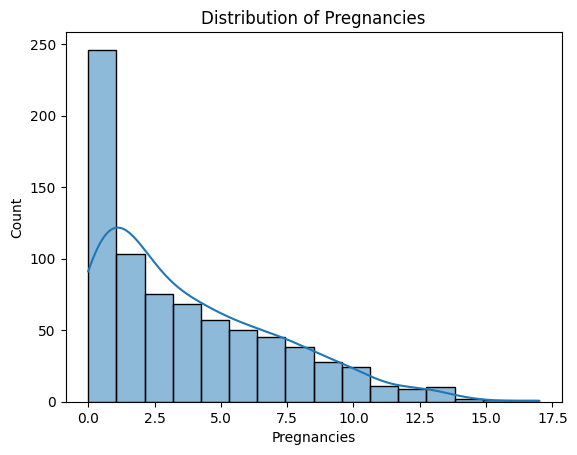

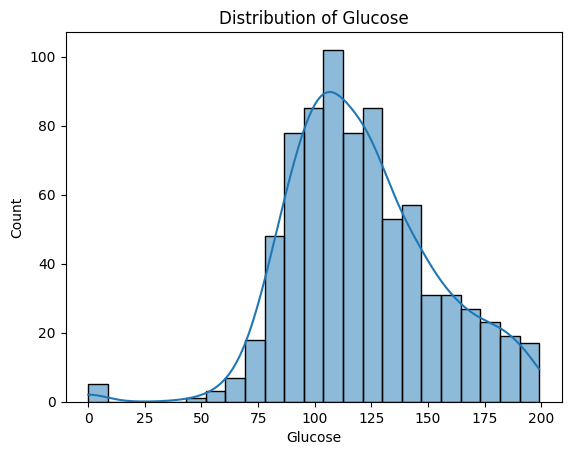

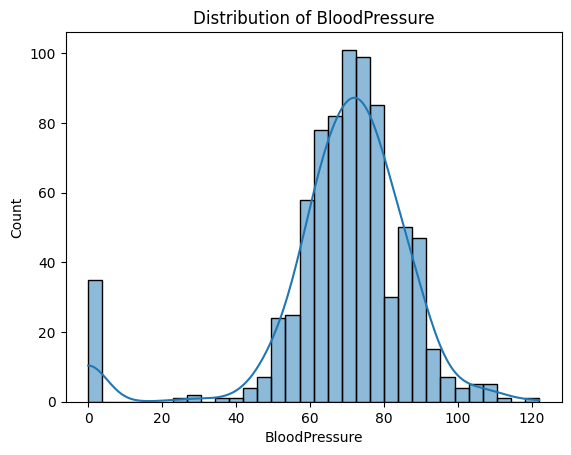

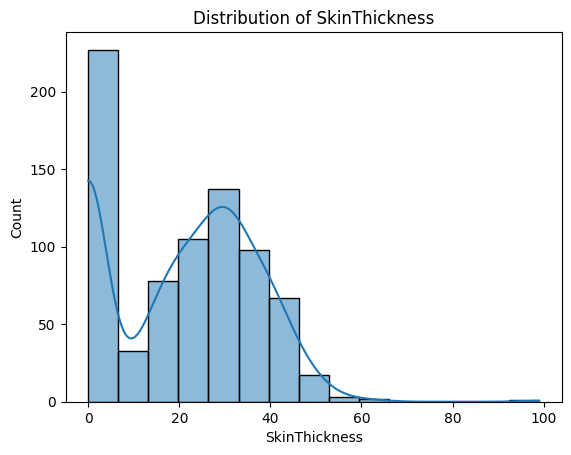

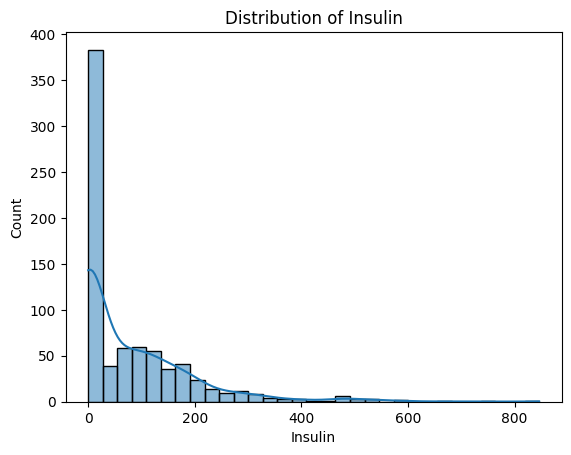

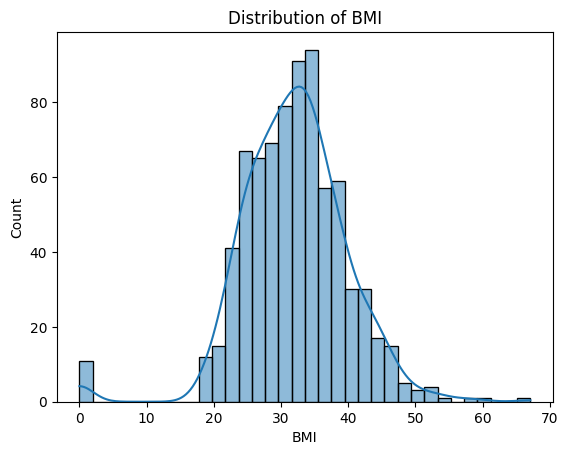

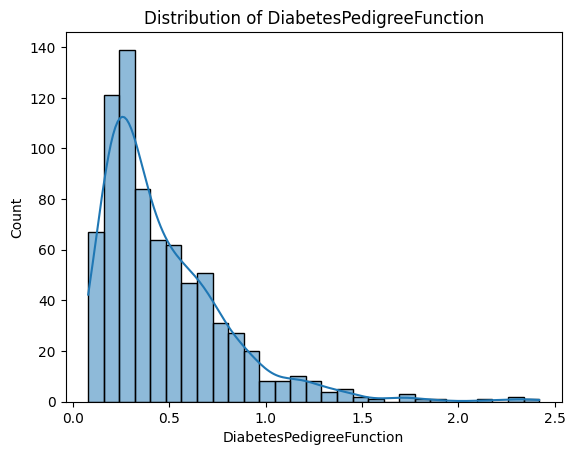

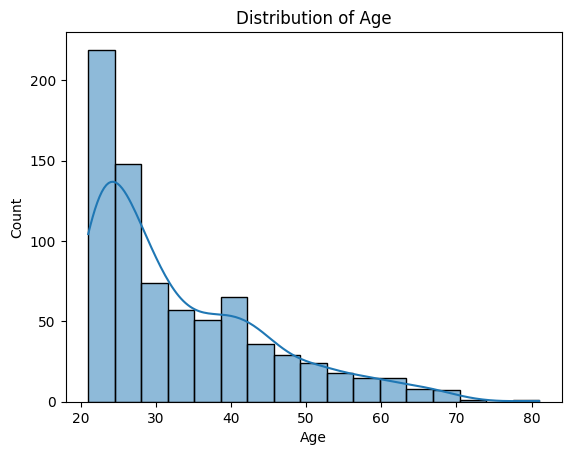

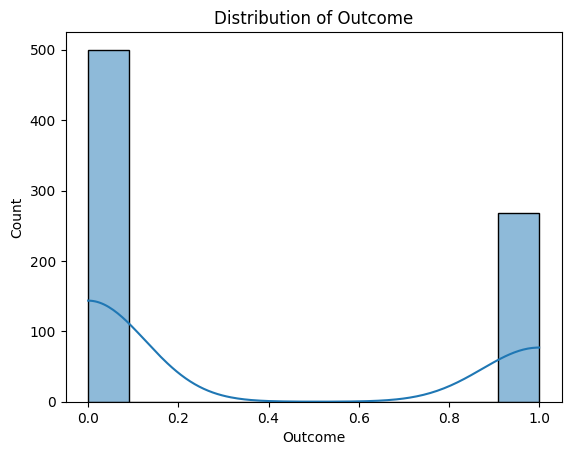

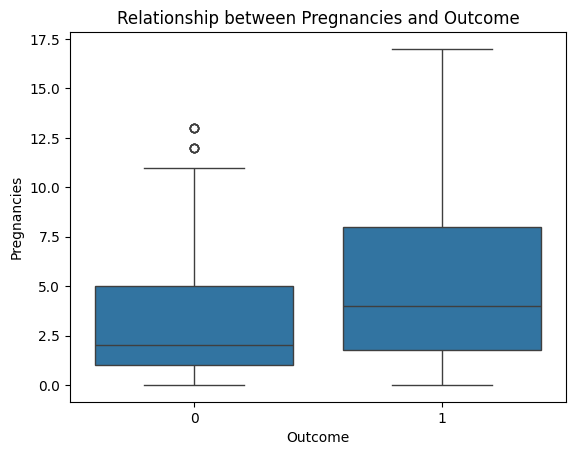

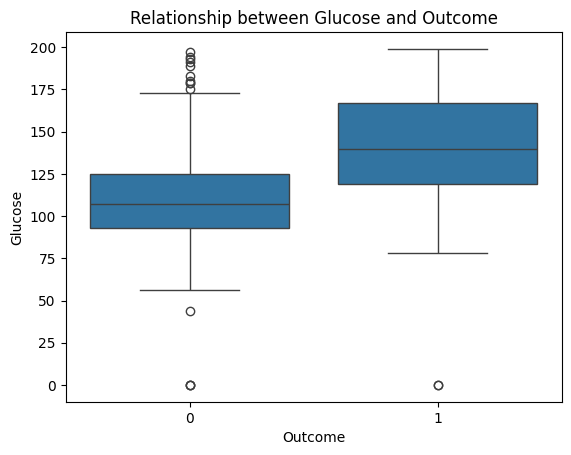

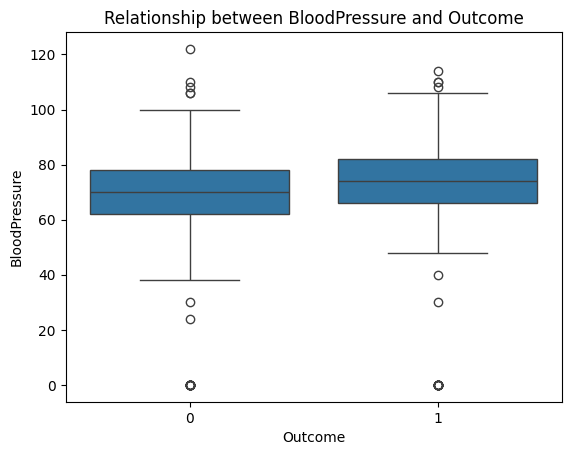

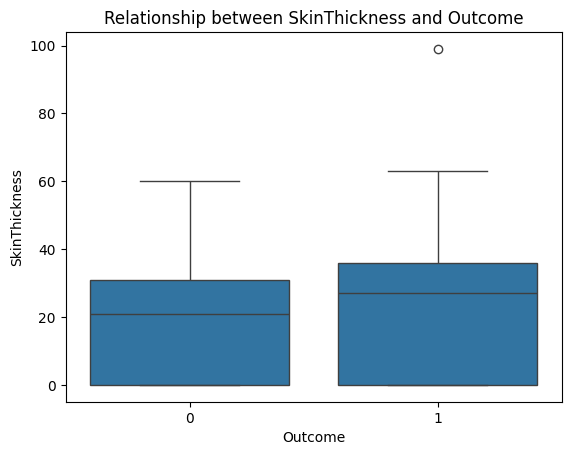

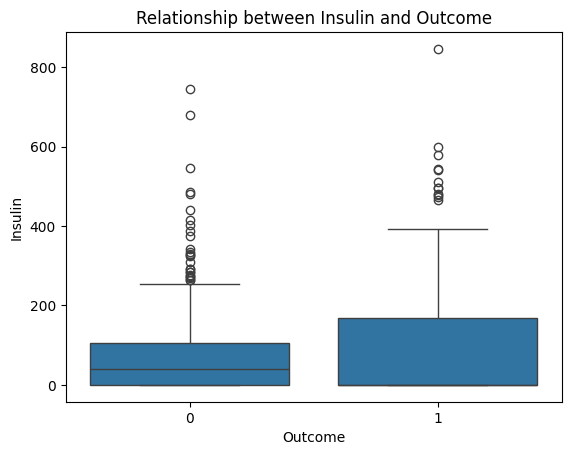

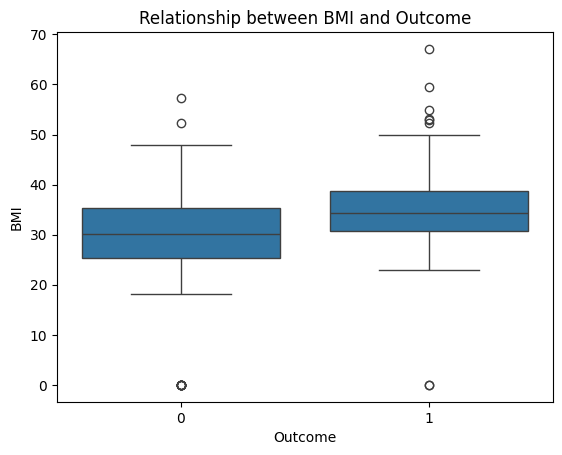

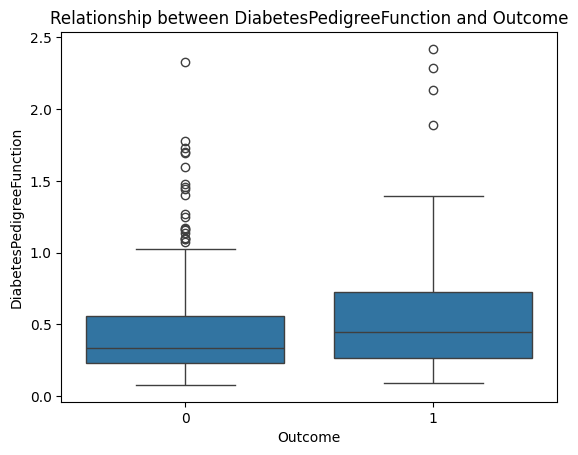

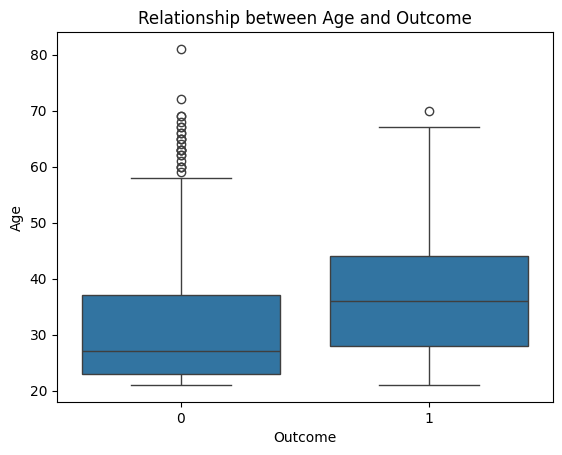

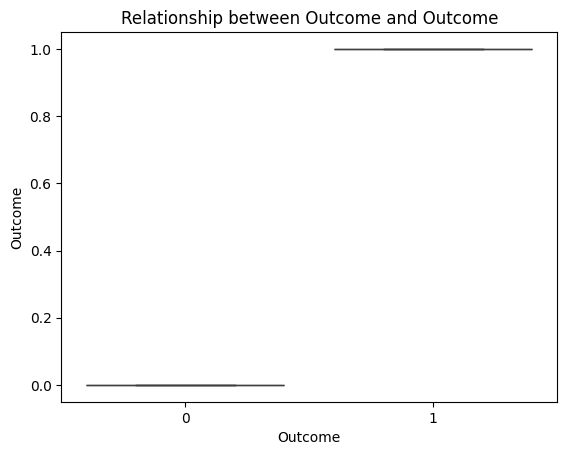

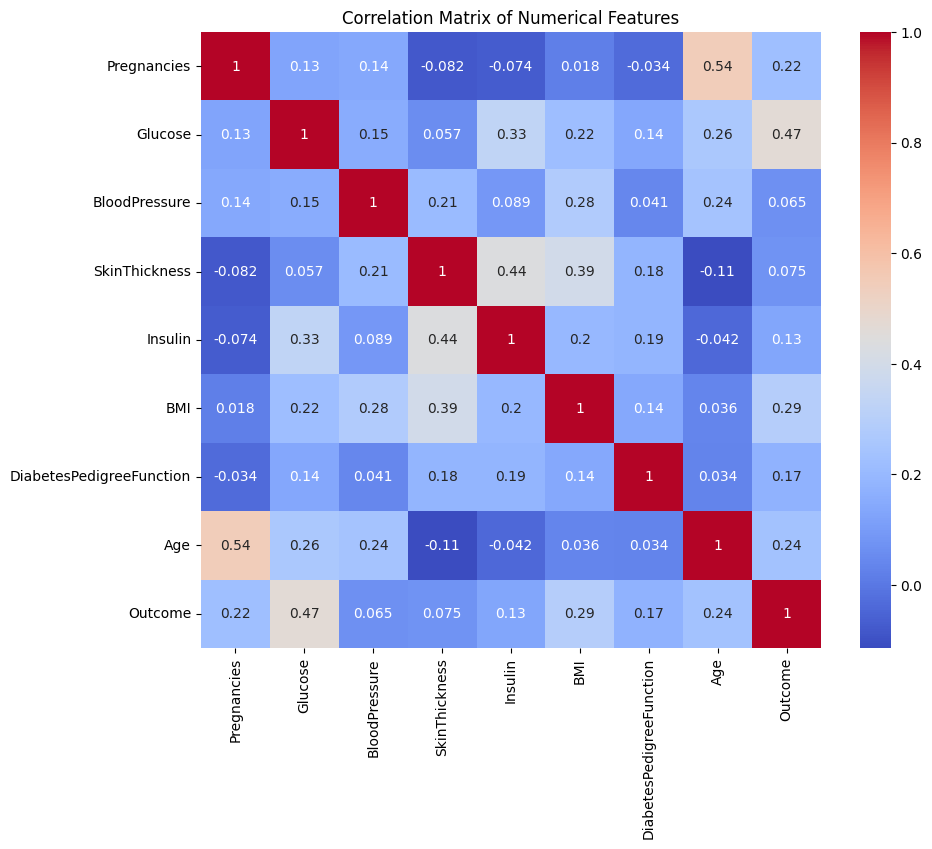

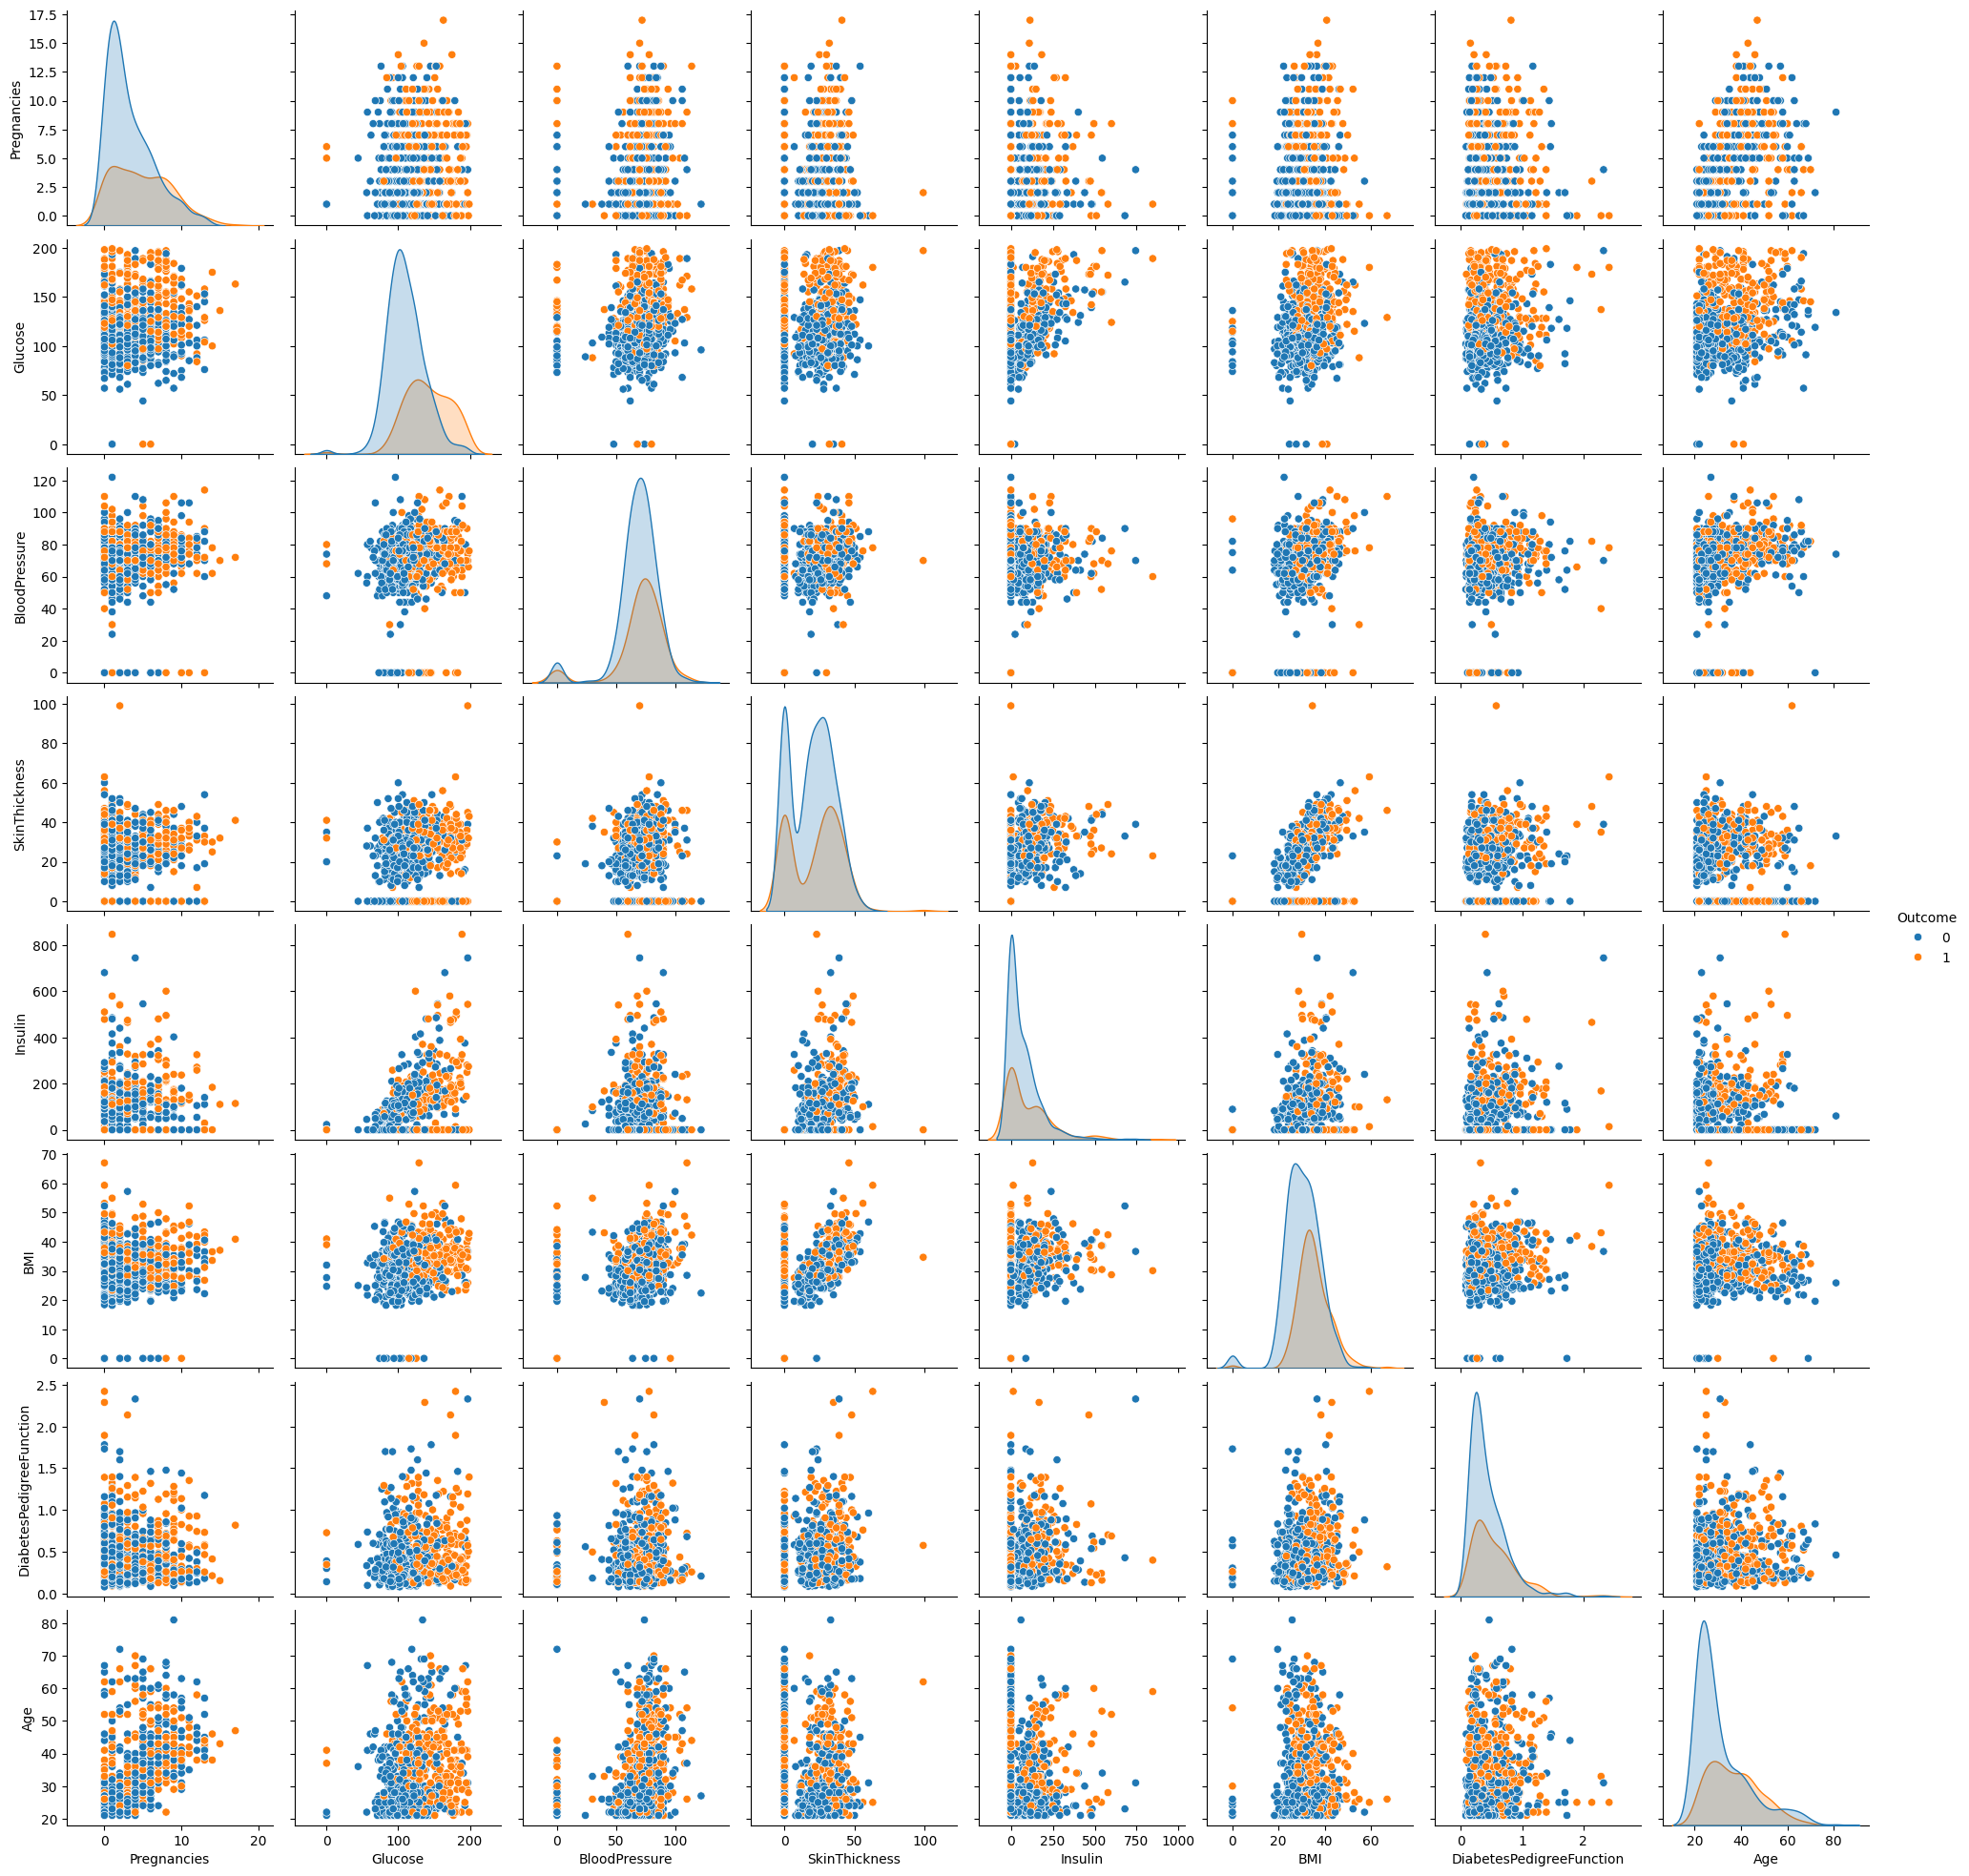

In [42]:
print(data.describe())

# Display the first few rows of the dataset
print(data.head())

# Get information about the dataset
print(data.info())

# Generate descriptive statistics
print(data.describe())

# Check for missing values
print(data.isnull().sum())


# Visualize the distribution of numerical features
numerical_features = data.select_dtypes(include=['number']).columns
for col in numerical_features:
    plt.figure()
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Analyze the relationship between features and the target variable
for col in numerical_features:
    plt.figure()
    sns.boxplot(x='Outcome', y=col, data=data)
    plt.title(f'Relationship between {col} and Outcome')
    plt.show()

# Create a correlation matrix to visualize the relationships between numerical features
plt.figure(figsize=(10,8))
sns.heatmap(data[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


# Explore the relationship between pairs of features
sns.pairplot(data, hue='Outcome')
plt.show()

# 4. Preprocessing

## a. Menghapus outlier dengan metode IQR

In [43]:
#Menghapus outlier dengan metode IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

numerical_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                      'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

data_cleaned = remove_outliers(data, numerical_features)
data_cleaned

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
5,5,116,74,0,0,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## b. Memilih fitur

In [44]:
X = data_cleaned.drop(columns='Outcome', axis=1)
y = data_cleaned['Outcome']
mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print("Mutual Information Scores:")
print(mi_scores)

Mutual Information Scores:
Glucose                     0.117304
Age                         0.073250
BMI                         0.064185
BloodPressure               0.059552
Pregnancies                 0.032473
Insulin                     0.031709
SkinThickness               0.026198
DiabetesPedigreeFunction    0.000000
dtype: float64


In [45]:
top_features = mi_scores.head(6)
print("Top 6 Features based on Mutual Information Scores:")
print(top_features)

Top 6 Features based on Mutual Information Scores:
Glucose          0.117304
Age              0.073250
BMI              0.064185
BloodPressure    0.059552
Pregnancies      0.032473
Insulin          0.031709
dtype: float64


In [46]:
# Pilih 6 fitur terbaik berdasarkan MI
top_features = mi_scores.head(6).index

# Ambil data X hanya dengan fitur terbaik
X_selected = X[top_features]
X_selected

,Glucose,Age,BMI,BloodPressure,Pregnancies,Insulin
0,148,50,33.6,72,6,0
1,85,31,26.6,66,1,0
2,183,32,23.3,64,8,0
3,89,21,28.1,66,1,94
5,116,30,25.6,74,5,0
...,...,...,...,...,...,...
763,101,63,32.9,76,10,180
764,122,27,36.8,70,2,0
765,121,30,26.2,72,5,112
766,126,47,30.1,60,1,0


## c. Memisahkan data X dan Y 

In [47]:
X = X_selected
Y = y

In [48]:
print(X)

     Glucose  Age   BMI  BloodPressure  Pregnancies  Insulin
0        148   50  33.6             72            6        0
1         85   31  26.6             66            1        0
2        183   32  23.3             64            8        0
3         89   21  28.1             66            1       94
5        116   30  25.6             74            5        0
..       ...  ...   ...            ...          ...      ...
763      101   63  32.9             76           10      180
764      122   27  36.8             70            2        0
765      121   30  26.2             72            5      112
766      126   47  30.1             60            1        0
767       93   23  30.4             70            1        0

[636 rows x 6 columns]


In [49]:
print(Y)

0      1
1      0
2      1
3      0
5      0
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 636, dtype: int64


## d. standarisasi data

In [55]:
scaler = StandardScaler()
standarize_data = scaler.fit_transform(X)
print(standarize_data)

[[ 1.00540261e+00  1.60468837e+00  2.56438414e-01 -6.96199653e-04
   6.81425557e-01 -8.26197176e-01]
 [-1.16896300e+00 -1.43040721e-01 -8.40893209e-01 -5.32035774e-01
  -8.57589551e-01 -8.26197176e-01]
 [ 2.21338350e+00 -5.10549792e-02 -1.35820669e+00 -7.09148966e-01
   1.29703160e+00 -8.26197176e-01]
 ...
 [ 7.35316313e-02 -2.35026462e-01 -9.03597873e-01 -6.96199653e-04
   3.73622536e-01  5.14540431e-01]
 [ 2.46100331e-01  1.32873114e+00 -2.92227397e-01 -1.06337535e+00
  -8.57589551e-01 -8.26197176e-01]
 [-8.92853085e-01 -8.78926652e-01 -2.45198899e-01 -1.77809391e-01
  -8.57589551e-01 -8.26197176e-01]]


In [91]:
# simpan scaler
scaler_filename = "scaler.sav"
pickle.dump(scaler, open(scaler_filename, 'wb'))

In [56]:
X = standarize_data
Y = Y

In [57]:
print(X)
print(Y)

[[ 1.00540261e+00  1.60468837e+00  2.56438414e-01 -6.96199653e-04
   6.81425557e-01 -8.26197176e-01]
 [-1.16896300e+00 -1.43040721e-01 -8.40893209e-01 -5.32035774e-01
  -8.57589551e-01 -8.26197176e-01]
 [ 2.21338350e+00 -5.10549792e-02 -1.35820669e+00 -7.09148966e-01
   1.29703160e+00 -8.26197176e-01]
 ...
 [ 7.35316313e-02 -2.35026462e-01 -9.03597873e-01 -6.96199653e-04
   3.73622536e-01  5.14540431e-01]
 [ 2.46100331e-01  1.32873114e+00 -2.92227397e-01 -1.06337535e+00
  -8.57589551e-01 -8.26197176e-01]
 [-8.92853085e-01 -8.78926652e-01 -2.45198899e-01 -1.77809391e-01
  -8.57589551e-01 -8.26197176e-01]]
0      1
1      0
2      1
3      0
5      0
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 636, dtype: int64


## Spliting data trianing dan testing

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Cek hasil
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (508, 6)
X_test shape: (128, 6)
y_train shape: (508,)
y_test shape: (128,)


# 4. Model

## a. Model Logistic Regression

### model

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model_log_reg = LogisticRegression(max_iter=1000)

#hyperparameter
param_grid_log_reg = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l2'],
}

grid_search_log_reg = GridSearchCV(estimator=model_log_reg, param_grid=param_grid_log_reg, cv=5, n_jobs=-1)

grid_search_log_reg.fit(X, Y)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear']})

### Evaluasi

In [75]:
print("Best Hyperparameters for Logistic Regression:", grid_search_log_reg.best_params_)

y_pred_log_reg_cv = grid_search_log_reg.best_estimator_.predict(X)

accuracy_log_reg = accuracy_score(Y, y_pred_log_reg_cv)
print("Logistic Regression Accuracy from GridSearch:", accuracy_log_reg)
print("\nClassification Report:")
print(classification_report(Y, y_pred_log_reg_cv))

Best Hyperparameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression Accuracy from GridSearch: 0.7861635220125787

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       439
           1       0.72      0.51      0.60       197

    accuracy                           0.79       636
   macro avg       0.76      0.71      0.72       636
weighted avg       0.78      0.79      0.77       636



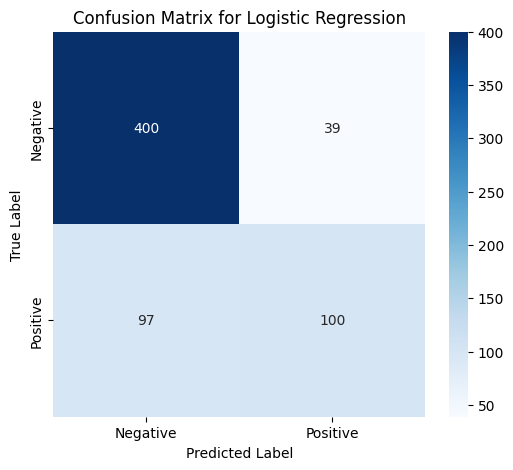

In [76]:
# Hitung confusion matrix
cm = confusion_matrix(y, y_pred_log_reg_cv)

# Buat plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

## b. Model Decision Tree Classifier

### Model

In [77]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model_dt = DecisionTreeClassifier(random_state=42)

param_grid_dt = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
}

grid_search_dt = GridSearchCV(estimator=model_dt, param_grid=param_grid_dt, cv=5, n_jobs=-1)

grid_search_dt.fit(X, Y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

### Evaluasi

In [78]:
print("Best Hyperparameters for Decision Tree:", grid_search_dt.best_params_)

y_pred_dt_cv = grid_search_dt.best_estimator_.predict(X)

accuracy_dt = accuracy_score(Y, y_pred_dt_cv)
print("Decision Tree Accuracy from GridSearch:", accuracy_dt)
print("\nClassification Report:")
print(classification_report(Y, y_pred_dt_cv))

Best Hyperparameters for Decision Tree: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Decision Tree Accuracy from GridSearch: 0.8191823899371069

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       439
           1       0.68      0.77      0.73       197

    accuracy                           0.82       636
   macro avg       0.79      0.81      0.80       636
weighted avg       0.83      0.82      0.82       636



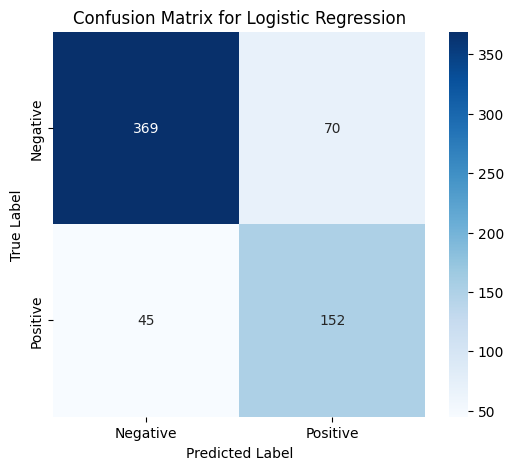

In [79]:
# Hitung confusion matrix
cm = confusion_matrix(Y, y_pred_dt_cv)

# Buat plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

## c. Model Support Vector Machine

### model

In [80]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model_svm = SVC(random_state=42)

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}

grid_search_svm = GridSearchCV(estimator=model_svm, param_grid=param_grid_svm, cv=5, n_jobs=-1)

grid_search_svm.fit(X, Y)

GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']})

### Evaluasi

In [82]:
print("Best Hyperparameters for SVM:", grid_search_svm.best_params_)

y_pred_svm_cv = grid_search_svm.best_estimator_.predict(X)

accuracy_svm = accuracy_score(Y, y_pred_svm_cv)
print("SVM Accuracy from GridSearch:", accuracy_svm)
print("\nClassification Report:")
print(classification_report(Y, y_pred_svm_cv))

Best Hyperparameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
SVM Accuracy from GridSearch: 0.779874213836478

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       439
           1       0.69      0.53      0.60       197

    accuracy                           0.78       636
   macro avg       0.75      0.71      0.72       636
weighted avg       0.77      0.78      0.77       636



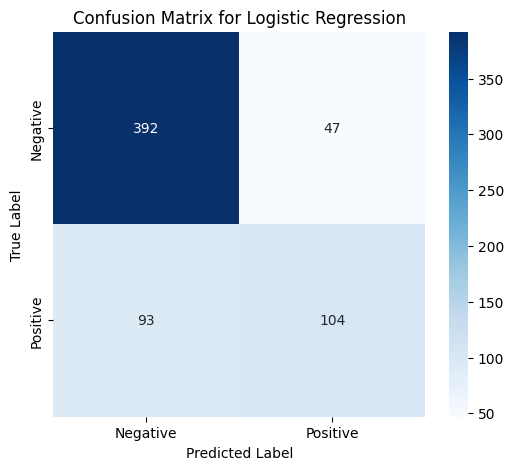

In [84]:
# Hitung confusion matrix
cm = confusion_matrix(Y, y_pred_svm_cv)

# Buat plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

# Prediksi

In [87]:
input_data = (183,32,23.3,64,8,0)

input_data_as_numpy_array = np.array(input_data)
input_data_reshape = input_data_as_numpy_array.reshape(1,-1)

std_data = scaler.transform(input_data_reshape)
print(std_data)

prediction = grid_search_dt.best_estimator_.predict(std_data)
print(prediction)

if (prediction[0]==0):
    print('pasien tidak terkena diabetes')
else:
    print('pasien terkena diabetes')

[[ 2.2133835  -0.05105498 -1.35820669 -0.70914897  1.2970316  -0.82619718]]
[1]
pasien terkena diabetes


d:\2025\3. PORTOFOLIO\PYTHON\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# 7.Simpan Model

In [88]:
import pickle

filename_dt = 'model_dt.sav'
pickle.dump(grid_search_dt.best_estimator_, open(filename_dt, 'wb'))